Import Libraries

In [1]:
import re, nltk
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import gensim
from gensim.models.phrases import Phrases, Phraser

Cleaning Papaer Titles using a function

Function to remove regular expressions, stop word and lemmatization.

In [2]:
def normalizer(title):
    soup = BeautifulSoup(title, 'html.parser')   # removing HTML encoding such as ‘&amp’,’&quot’
    souped = soup.get_text()
    only_words = re.sub("(@[A-Za-z0-9]+)|([^A-Za-z \t])|(\w+:\/\\\S+)|([()[\]{}])"," ", souped)
    
    phrases = Phrases(only_words, min_count=5, threshold=100)
    bigram = Phraser(phrases)
    

    tokens = nltk.word_tokenize(only_words)
    removed_letters = [word for word in tokens if len(word)>2] # removing words with length less than or equal to 2
    lower_case = [l.lower() for l in removed_letters]

    stop_words = set(stopwords.words('english'))
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case))
    bigrams = bigram[filtered_result]
    
    

    wordnet_lemmatizer = WordNetLemmatizer()
    lemmas = [wordnet_lemmatizer.lemmatize(t) for t in bigrams]
    return lemmas

Loading unprocessed dataset with Paper titles. 

In [3]:
df = pd.read_csv("E:\\Graduate Programs\\Dissertation\\TopiModellingJupyter\\arxiv-papers.csv", encoding = "ISO-8859-1")
pd.set_option('display.max_colwidth', -1)


In [52]:
num_words = df['title'].apply(lambda x: len(x.split()))
print(sum(num_words))

937336


Normalising Titles

In [4]:
df['normalized_titles'] = df.title.apply(normalizer)
df = df[df['normalized_titles'].map(len) > 0] # removing rows with normalized titles of length 0
print("Printing top 5 rows of dataframe showing original and cleaned titles....")
print(df.head())


Printing top 5 rows of dataframe showing original and cleaned titles....
      arxiv_id  archive_size  \
0  0704.0004v1  9486           
1  0704.0010v1  45695          
2  0704.0012v1  9560           
3  0704.0858v1  355195         
4  0704.0861v1  693752         

                                                             sha256  \
0  83b5c83d0963d796ed61fae5ed47cac55d2c942d41e03f1b776c283abc4c0af8   
1  6dd40a2af3e336e0a8e94a5a20a1075819af829f1fcef70f8e73078cb70e174e   
2  7f7997eee4e571f22551c06bf25e2315ac27fc663273c1bdc8d3ef24887e2b45   
3  723ba50cc7a5d0d2454df543d6aaacd5948a1bb4690459ac7610af1c9919c363   
4  05f2ae4019a2740a8ef53074656ea9de50324150042fd981a42887d08df120c2   

                                                                                                   title  \
0  A determinant of Stirling cycle numbers counts unlabeled acyclic single-source automata                 
1  Partial cubes: structures, characterizations, and constructions                         

In [5]:
df.drop(['arxiv_id', 'archive_size', 'sha256', 'sections', 'tables', 'status'], axis=1, inplace=True)
print(df.head())

                                                                                                   title  \
0  A determinant of Stirling cycle numbers counts unlabeled acyclic single-source automata                 
1  Partial cubes: structures, characterizations, and constructions                                         
2  Distribution of integral Fourier Coefficients of a Modular Form of Half Integral Weight Modulo Primes   
3  Lessons Learned from the deployment of a high-interaction honeypot                                      
4  Empirical analysis and statistical modeling of attack processes based on honeypots                      

                                                                                      normalized_titles  
0  [determinant, stirling, cycle, number, count, unlabeled, acyclic, single, source, automaton]          
1  [partial, cube, structure, characterization, construction]                                            
2  [distribution, integral, fouri

Saving cleaned titles to csv

In [6]:
df.to_csv('cleaned_data.csv', encoding='utf-8', index=False)
cleaned_data = pd.read_csv("cleaned_data.csv", encoding = "ISO-8859-1")
pd.set_option('display.max_colwidth', -1)
data = cleaned_data.normalized_titles
print(data.head())

0    ['determinant', 'stirling', 'cycle', 'number', 'count', 'unlabeled', 'acyclic', 'single', 'source', 'automaton']          
1    ['partial', 'cube', 'structure', 'characterization', 'construction']                                                      
2    ['distribution', 'integral', 'fourier', 'coefficient', 'modular', 'form', 'half', 'integral', 'weight', 'modulo', 'prime']
3    ['lesson', 'learned', 'deployment', 'high', 'interaction', 'honeypot']                                                    
4    ['empirical', 'analysis', 'statistical', 'modeling', 'attack', 'process', 'based', 'honeypot']                            
Name: normalized_titles, dtype: object


In [53]:
num_words2 = data.apply(lambda x: len(x.split()))
print(sum(num_words2))

782311


Importing Gensim package

In [7]:
import gensim
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
from pprint import pprint

Finalising dictionary and corpus

In [8]:
import itertools
from itertools import islice
dataset = [d.split() for d in data]
dictionary = Dictionary(dataset)
corpus = [dictionary.doc2bow(text) for text in dataset]

dic = {}
dic.update(dictionary.token2id)
dict(islice(dic.items(), 0, 20))



{"'acyclic',": 0,
 "'automaton']": 1,
 "'count',": 2,
 "'cycle',": 3,
 "'number',": 4,
 "'single',": 5,
 "'source',": 6,
 "'stirling',": 7,
 "'unlabeled',": 8,
 "['determinant',": 9,
 "'characterization',": 10,
 "'construction']": 11,
 "'cube',": 12,
 "'structure',": 13,
 "['partial',": 14,
 "'coefficient',": 15,
 "'form',": 16,
 "'fourier',": 17,
 "'half',": 18,
 "'integral',": 19}

In [9]:
print(len(dictionary))

43709


In [10]:
print(corpus[:20])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)], [(10, 1), (11, 1), (12, 1), (13, 1), (14, 1)], [(15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1)], [(25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1)], [(27, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1)], [(38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1)], [(49, 1), (50, 1), (51, 1), (52, 1), (53, 1)], [(54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1)], [(64, 1), (65, 1), (66, 1), (67, 1), (68, 1)], [(40, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1)], [(75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1)], [(69, 1), (81, 1), (82, 1), (83, 1), (84, 1)], [(85, 1), (86, 1), (87, 1), (88, 1), (89, 1)], [(90, 1), (91, 1), (92, 1), (93, 1), (94, 1)], [(28, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104

In [11]:
print(len(corpus))

104708


Applying Models : LSI, LDA, HDP and NMF
1st Model : LSI (Latent Semantic Indexing)

In [54]:
def evaluate_lsi(dictionary, corpus, texts, limit, start=5, step=5):
    """
    Function to display num_topics - LSI graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lsm_list : List of LSI topic models
    c_v : Coherence values corresponding to the LSI model with respective number of topics
    """
    c_v = []
    lsm_list = []
    for num_topics in range(start, limit, step):
        lsm = LsiModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        lsm_list.append(lsm)
        cm = CoherenceModel(model=lsm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())
        
    # Show graph
    x = range(start, limit, step)
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()
    plt.savefig('Lsi_ParameterTuningFinal1.png')
    return lsm_list, c_v

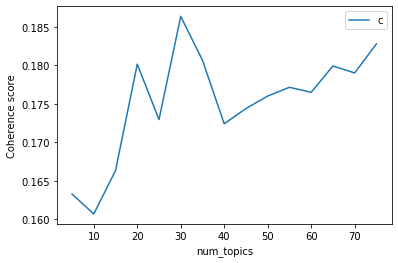

<Figure size 432x288 with 0 Axes>

In [55]:
lsmlist, c_v1 = evaluate_lsi(dictionary=dictionary, corpus=corpus, texts=dataset, start=5, limit=80, step=5)

In [56]:
x = range(5, 80, 5)
for m, cv in zip(x, c_v1):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 5  has Coherence Value of 0.1633
Num Topics = 10  has Coherence Value of 0.1607
Num Topics = 15  has Coherence Value of 0.1663
Num Topics = 20  has Coherence Value of 0.1801
Num Topics = 25  has Coherence Value of 0.1729
Num Topics = 30  has Coherence Value of 0.1864
Num Topics = 35  has Coherence Value of 0.1806
Num Topics = 40  has Coherence Value of 0.1724
Num Topics = 45  has Coherence Value of 0.1744
Num Topics = 50  has Coherence Value of 0.176
Num Topics = 55  has Coherence Value of 0.1771
Num Topics = 60  has Coherence Value of 0.1765
Num Topics = 65  has Coherence Value of 0.1799
Num Topics = 70  has Coherence Value of 0.179
Num Topics = 75  has Coherence Value of 0.1828


In [61]:
lsimodel = LsiModel(corpus=corpus, num_topics=20, id2word=dictionary)
#lsimodel.show_topics()

2nd Model : HDP (Hierarchical Dirichlet Process)

In [16]:
hdpmodel = HdpModel(corpus=corpus, id2word=dictionary)
#hdpmodel.show_topics()

3rd Model : LDA (Latent Dirichlet Allocation)

In [58]:
def evaluate_graph(dictionary, corpus, texts, limit, start=5, step=5):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    c_v = []
    lm_list = []
    for num_topics in range(start, limit, step):
        lm = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())
        
    # Show graph
    x = range(start, limit, step)
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()
    plt.savefig('Lda_ParameterTuningFinal1.png')
    return lm_list, c_v

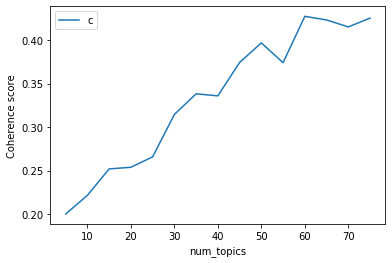

<Figure size 432x288 with 0 Axes>

In [59]:
lmlist, c_v2 = evaluate_graph(dictionary=dictionary, corpus=corpus, texts=dataset, start=5,limit=80, step=5)

In [60]:
x = range(5, 80, 5)
for m, cv in zip(x, c_v2):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 5  has Coherence Value of 0.2001
Num Topics = 10  has Coherence Value of 0.2215
Num Topics = 15  has Coherence Value of 0.2519
Num Topics = 20  has Coherence Value of 0.2538
Num Topics = 25  has Coherence Value of 0.2658
Num Topics = 30  has Coherence Value of 0.3145
Num Topics = 35  has Coherence Value of 0.3382
Num Topics = 40  has Coherence Value of 0.3359
Num Topics = 45  has Coherence Value of 0.3743
Num Topics = 50  has Coherence Value of 0.3968
Num Topics = 55  has Coherence Value of 0.3741
Num Topics = 60  has Coherence Value of 0.4273
Num Topics = 65  has Coherence Value of 0.4231
Num Topics = 70  has Coherence Value of 0.4152
Num Topics = 75  has Coherence Value of 0.4253


Coherence reaches max value at the number of topics  = 

In [62]:
ldamodel = LdaModel(corpus=corpus, num_topics=35, id2word=dictionary)
#ldamodel.show_topics()

4th Model : Non-Negative Matrix Factorization

In [21]:
from gensim.models.nmf import Nmf

In [63]:
def evaluate_graph(dictionary, corpus, texts, limit, start=5, step=5):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    c_v = []
    nmf_list = []
    for num_topics in range(start, limit, step):
        nmf = Nmf(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        nmf_list.append(nmf)
        cm = CoherenceModel(model=nmf, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())
        
    # Show graph
    x = range(start, limit, step)
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()
    plt.savefig('NMF_ParameterTuningFinal1.png')
    return nmf_list, c_v

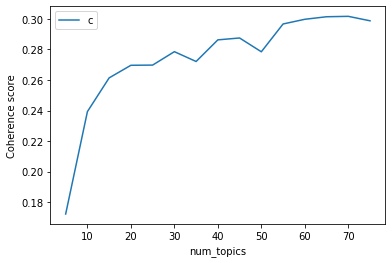

<Figure size 432x288 with 0 Axes>

In [64]:
nmflist, c_v3 = evaluate_graph(dictionary=dictionary, corpus=corpus, texts=dataset, start=5, limit=80, step=5)

In [65]:
x = range(5, 80, 5)
for m, cv in zip(x, c_v3):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 5  has Coherence Value of 0.1723
Num Topics = 10  has Coherence Value of 0.2393
Num Topics = 15  has Coherence Value of 0.2614
Num Topics = 20  has Coherence Value of 0.2696
Num Topics = 25  has Coherence Value of 0.2698
Num Topics = 30  has Coherence Value of 0.2786
Num Topics = 35  has Coherence Value of 0.2721
Num Topics = 40  has Coherence Value of 0.2863
Num Topics = 45  has Coherence Value of 0.2875
Num Topics = 50  has Coherence Value of 0.2785
Num Topics = 55  has Coherence Value of 0.2967
Num Topics = 60  has Coherence Value of 0.2998
Num Topics = 65  has Coherence Value of 0.3014
Num Topics = 70  has Coherence Value of 0.3017
Num Topics = 75  has Coherence Value of 0.2988


In [66]:
nmfmodel = Nmf(corpus=corpus, num_topics=35, id2word=dictionary)
#nmfmodel.show_topics()

Evaluating all the topic models


Storing topics for each model

In [67]:
lsitopics = lsimodel.show_topics(formatted=False)
hdptopics = hdpmodel.show_topics(formatted=False)
ldatopics = ldamodel.show_topics(formatted=False)
nmftopics = nmfmodel.show_topics(formatted=False)

In [68]:
lsitopics = [[word for word, prob in topic] for topicid, topic in lsitopics]
hdptopics = [[word for word, prob in topic] for topicid, topic in hdptopics]
ldatopics = [[word for word, prob in topic] for topicid, topic in ldatopics]
nmftopics = [[word for word, prob in topic] for topicid, topic in nmftopics]

In [69]:
lsi_coherence = CoherenceModel(topics=lsitopics, texts=dataset, dictionary=dictionary, window_size=10).get_coherence()
hdp_coherence = CoherenceModel(topics=hdptopics, texts=dataset, dictionary=dictionary, window_size=10).get_coherence()
lda_coherence = CoherenceModel(topics=ldatopics, texts=dataset, dictionary=dictionary, window_size=10).get_coherence()
nmf_coherence = CoherenceModel(topics=nmftopics, texts=dataset, dictionary=dictionary, window_size=10).get_coherence()

In [70]:
def evaluate_bar_graph(coherences, indices):
    """
    Function to plot bar graph.
    
    coherences: list of coherence values
    indices: Indices to be used to mark bars. Length of this and coherences should be equal.
    """
    assert len(coherences) == len(indices)
    n = len(coherences)
    x = np.arange(n)
    plt.bar(x, coherences, width=0.2, tick_label=indices, align='center')
    plt.xlabel('Models')
    plt.ylabel('Coherence Value')
    plt.savefig('ModelEvalutionFinal1.png')

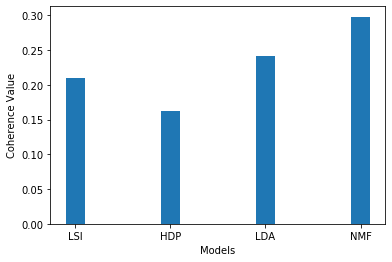

In [71]:
evaluate_bar_graph([lsi_coherence, hdp_coherence, lda_coherence, nmf_coherence],
                   ['LSI', 'HDP', 'LDA', 'NMF'])

In [31]:
#import pyLDAvis.gensim
#pyLDAvis.enable_notebook()
#pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

Clearly NMF has higher coherence score.

Dominant Topic for each document

In [72]:
get_document_topics = nmfmodel.get_document_topics(corpus[0])
print(get_document_topics)

[(0, 0.024847758376835463), (1, 0.014779579804285344), (2, 0.011201269687153884), (5, 0.015412005013750913), (8, 0.017897591230206355), (9, 0.01759798020227623), (10, 0.020079162338145332), (11, 0.017962073853818407), (13, 0.07468024971702185), (16, 0.041997347439119696), (19, 0.015729937525209937), (20, 0.12444583743635672), (22, 0.0130783769049535), (23, 0.07345788739725587), (24, 0.06832237306748695), (28, 0.04371601757363863), (29, 0.22995964827451407), (31, 0.04951507745243679), (32, 0.0291805360447847), (33, 0.05749023919983689), (34, 0.018981606731469074)]


In [73]:
def format_topics_sentences(finalmodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(finalmodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = finalmodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(finalmodel=nmfmodel, corpus=corpus, texts=dataset)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,29.0,0.2304,"'estimation',, 'graph',, 'pose',, 'supervised',, 'depth',, 'image'], 'single',, 'density',, 'parameter',, 'semi',","[['determinant',, 'stirling',, 'cycle',, 'number',, 'count',, 'unlabeled',, 'acyclic',, 'single',, 'source',, 'automaton']]"
1,1,3.0,0.1454,"'kernel',, 'vector',, 'machine',, 'analysis'], 'support',, 'network',, 'machine'], 'multiple',, 'quantum',, 'space',","[['partial',, 'cube',, 'structure',, 'characterization',, 'construction']]"
2,2,28.0,0.1686,"'set',, 'system'], 'answer',, 'modeling',, 'random',, 'programming'], 'level',, 'question',, 'programming',, 'language',","[['distribution',, 'integral',, 'fourier',, 'coefficient',, 'modular',, 'form',, 'half',, 'integral',, 'weight',, 'modulo',, 'prime']]"
3,3,15.0,0.9562,"'high',, 'method',, 'sparse',, 'dimensional',, 'matrix',, 'data'], ['efficient',, 'resolution',, ['fast',, 'gradient',","[['lesson',, 'learned',, 'deployment',, 'high',, 'interaction',, 'honeypot']]"
4,4,4.0,0.3969,"'based',, 'graph',, 'system'], 'attention',, 'segmentation',, 'cnn',, 'prediction',, 'text',, 'rule',, 'vision',","[['empirical',, 'analysis',, 'statistical',, 'modeling',, 'attack',, 'process',, 'based',, 'honeypot']]"
5,5,31.0,0.5190,"'data',, 'driven',, 'big',, 'analysis'], 'augmentation',, 'training',, 'mining',, 'augmentation'], 'stream'], 'set']","[['multimodal',, 'nested',, 'sampling',, 'efficient',, 'robust',, 'alternative',, 'mcmc',, 'method',, 'astronomical',, 'data',, 'analysis']]"
6,6,13.0,0.2226,"'optimization',, 'data'], 'clustering',, 'function',, 'framework',, 'search',, 'convex',, 'algorithm'], 'belief',, 'mean',","[['avoiding',, 'rotated',, 'bitboards',, 'direct',, 'lookup']]"
7,7,7.0,0.8858,"'deep',, 'application',, 'classification'], 'optimal',, 'gradient',, 'training',, 'architecture',, 'net',, ['towards',, 'reinforcement',","[['garching',, 'bonn',, 'deep',, 'survey',, 'gabods',, 'wide',, 'field',, 'imaging',, 'reduction',, 'pipeline']]"
8,8,12.0,0.7630,"'network'], 'neural',, 'convolutional',, 'recurrent',, 'adversarial',, 'generative',, 'deep',, 'training',, 'graph',, 'fully',","[['multi',, 'dimensional',, 'recurrent',, 'neural',, 'network']]"
9,9,2.0,0.6778,"'linear',, 'non',, 'time',, 'application',, 'online',, 'optimal',, 'problem'], 'space',, 'regression',, 'bound',","[['aspect',, 'measurement',, 'error',, 'linear',, 'regression',, 'astronomical',, 'data']]"


In [74]:
df_dominant_topic.to_csv('DocumentsForEachTopic2.csv')

In [101]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.head(10)

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,29.0,"'estimation',, 'graph',, 'pose',, 'supervised',, 'depth',, 'image'], 'single',, 'density',, 'parameter',, 'semi',",2318.0,0.0221
1.0,3.0,"'kernel',, 'vector',, 'machine',, 'analysis'], 'support',, 'network',, 'machine'], 'multiple',, 'quantum',, 'space',",1929.0,0.0184
2.0,28.0,"'set',, 'system'], 'answer',, 'modeling',, 'random',, 'programming'], 'level',, 'question',, 'programming',, 'language',",2661.0,0.0254
3.0,15.0,"'high',, 'method',, 'sparse',, 'dimensional',, 'matrix',, 'data'], ['efficient',, 'resolution',, ['fast',, 'gradient',",4009.0,0.0383
4.0,4.0,"'based',, 'graph',, 'system'], 'attention',, 'segmentation',, 'cnn',, 'prediction',, 'text',, 'rule',, 'vision',",1290.0,0.0123
5.0,31.0,"'data',, 'driven',, 'big',, 'analysis'], 'augmentation',, 'training',, 'mining',, 'augmentation'], 'stream'], 'set']",2305.0,0.0220
6.0,13.0,"'optimization',, 'data'], 'clustering',, 'function',, 'framework',, 'search',, 'convex',, 'algorithm'], 'belief',, 'mean',",5840.0,0.0558
7.0,7.0,"'deep',, 'application',, 'classification'], 'optimal',, 'gradient',, 'training',, 'architecture',, 'net',, ['towards',, 'reinforcement',",488.0,0.0047
8.0,12.0,"'network'], 'neural',, 'convolutional',, 'recurrent',, 'adversarial',, 'generative',, 'deep',, 'training',, 'graph',, 'fully',",3058.0,0.0292
9.0,2.0,"'linear',, 'non',, 'time',, 'application',, 'online',, 'optimal',, 'problem'], 'space',, 'regression',, 'bound',",2502.0,0.0239


In [102]:
df_dominant_topics.to_csv('TopicandNumberofDocuments1.csv')

In [99]:
nmfmodel.show_topics(num_topics=35, num_words = 20)

[(0,
  '0.174*"\'time\'," + 0.050*"\'real\'," + 0.041*"\'series\'," + 0.022*"[\'real\'," + 0.014*"\'tree\'," + 0.009*"\'series\']" + 0.009*"\'dynamic\'," + 0.008*"\'based\'," + 0.007*"\'approximate\'," + 0.006*"\'continuous\'," + 0.006*"[\'new\'," + 0.006*"\'bayesian\'," + 0.005*"\'decision\'," + 0.005*"\'prediction\'," + 0.005*"\'markov\'," + 0.005*"\'optimization\'," + 0.004*"\'semantic\'," + 0.004*"\'multivariate\'," + 0.004*"\'event\'," + 0.004*"\'tracking\',"'),
 (1,
  '0.212*"\'model\']" + 0.035*"\'machine\'," + 0.026*"\'generative\'," + 0.020*"\'language\'," + 0.012*"\'sequence\'," + 0.012*"\'graphical\'," + 0.008*"\'neural\'," + 0.008*"\'translation\'," + 0.008*"\'mixture\'," + 0.007*"\'latent\'," + 0.007*"\'translation\']" + 0.007*"\'inference\'," + 0.006*"\'adversarial\'," + 0.006*"\'topic\'," + 0.006*"\'markov\'," + 0.006*"\'hidden\'," + 0.005*"\'variable\'," + 0.005*"\'block\'," + 0.005*"\'word\'," + 0.004*"\'generation\',"'),
 (2,
  '0.129*"\'linear\'," + 0.061*"\'non\'," 

Labelling the Topics

In [89]:
x=nmfmodel.show_topics(num_topics=35)

twords={}
for topic,word in x:
    twords[topic]=re.sub('[^A-Za-z ]+', '', word)    
print(twords)
dfOne = pd.DataFrame(list(twords.items()),columns = ['Topic','Words'])
dfOne.to_csv("TopicsLatest.csv")



{0: 'time  real  series  real  tree  series  dynamic  based  approximate  continuous', 1: 'model  machine  generative  language  sequence  graphical  neural  translation  mixture  latent', 2: 'linear  non  time  application  online  optimal  problem  space  regression  bound', 3: 'kernel  vector  machine  analysis  support  network  machine  multiple  quantum  space', 4: 'based  graph  system  attention  segmentation  cnn  prediction  text  rule  vision', 5: 'via  matrix  random  adversarial  graph  adaptive  segmentation  domain  tensor  robust', 6: 'network  neural  convolutional  recurrent  deep  deep  training  convolutional  adversarial  attention', 7: 'deep  application  classification  optimal  gradient  training  architecture  net  towards  reinforcement', 8: 'using  segmentation  prediction  convolutional  feature  automatic  classification  detection  word  image', 9: 'recognition  speech  end  action  entity  emotion  activity  video  object  human', 10: 'learning  optimizat

In [90]:
import wikipedia
import gensim
import random

def get_relevant_articles(keywords, search_depth=5, keyword_summary=5):
    """
    Searches through a list of keywords and returns keywords based on article headers
    in Wikipedia.    

    args:
    *  keywords: A list of keywords
    *  search_depth: how many wikipedia search results are checked, assumes to be between 1-10
    *  keyword_summary: gensim word argument to how many words should be used in summarization
    """
    if len(keywords) == 0:
        return []
    wiki = wikipedia

    keywords = [x.lower() for x in keywords]
    info = []
    for keyword in keywords:
        results = wiki.search(keyword)
        other_words = [x for x in keywords if x != keyword]
        
        if search_depth is not None:
            results = results[:search_depth]

        for result in results:
            
            try:
                article = wiki.page(result)
            except wikipedia.DisambiguationError as e:                    
                continue
            except wikipedia.PageError as e:
                continue
            summary_words = article.summary.lower().split(' ')
            has_words = any(word in summary_words for word in other_words)

            if has_words:
                info.append(article.title)

    try:
        info_keyword = gensim.summarization.keywords(' '.join(info),
                    words=keyword_summary).split('\n')
    except:
        print("keyword extraction failed, defaulting to article heading output")
        info_keyword = info[:]
    return info_keyword

In [91]:
topic_words = pd.read_csv("TopicsLatest.csv")
topicwords = topic_words.Words

In [92]:
for t in topicwords:
    labels = get_relevant_articles(t.split())
    print(labels)


C:\Users\Dell\Anaconda3\lib\site-packages\wikipedia\wikipedia.py:389: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file C:\Users\Dell\Anaconda3\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


['approximate', 'time', 'continuous', 'probability', 'delivery']
['model', 'network', 'generative', 'translation', 'translate', 'graphical']
['regression', 'optimization', 'optimal', 'online', 'space', 'cpu']
['machine', 'kernel', 'data analysis', 'tailored']
['segmentation', 'text', 'british', 'linux distributions']
['random variable', 'control', 'domain']
['network', 'recurrent', 'adversarial', 'database', 'convolutional']
['substructure', 'service', 'gradient', 'training']
['convolutional', 'convolution', 'detection', 'image segmentation', 'stellar']
['human', 'emotion', 'speech recognition', 'activity']
['convex', 'optimization', 'gradient', 'learning', 'particle']
['bayesian', 'markov', 'process', 'statistics', 'statistical inference']
['recurrent', 'neural network', 'generative adversarial']
['optimization', 'cluster', 'clustering', 'algorithm', 'search', 'convex']
['semantics', 'semantic', 'learning', 'opentext', 'skinner']
['matrix', 'sparse', 'independent', 'alveolar']
['artif